In [1]:
import matplotlib.pyplot as plt
import torch

In [2]:
prediction_path = 'reports/FIMImpuation/SynthData/09-04-1524/predictions.pth'

predictions = torch.load(prediction_path)


# Visualizations

In [3]:
# get 16 random samples
torch.manual_seed(42)
sample_ids = sorted(torch.randint(0, len(predictions['imputation_window']['target']), (16,)))
sample_ids = [v.item() for v in sample_ids]
print(sample_ids)


[14, 26, 67, 113, 210, 231, 335, 378, 414, 542, 572, 620, 876, 924, 950, 954]


In [4]:
def plot_sample(line_plot_data: dict, sample_id: int, ax):
    colors = ["red", "teal", "gold", "green", "red", "teal", "gold", "green"]
    batch_size, observed_window_count, _, _ = line_plot_data["observations"]["times"].shape

    imputation_times = line_plot_data["imputation_window"]["locations"][sample_id]
    imputation_target = line_plot_data["imputation_window"]["target"][sample_id]
    imputation_learnt = line_plot_data["imputation_window"]["learnt"][sample_id]

    for i in range(observed_window_count):
        obs_mask = line_plot_data["observations"]["mask"][sample_id, i, ...]
        obs_times = line_plot_data["observations"]["times"][sample_id, i, ...][~obs_mask]
        obs_values = line_plot_data["observations"]["values"][sample_id, i, ...][~obs_mask]

        ax.scatter(
            obs_times, sample_id * 0.5 + obs_values, color=colors[i], marker="x", label=f"observed window {i}"
        )
    ax.plot(
        imputation_times, sample_id * 0.5 + imputation_target, color="black", linestyle="--", label="target"
    )
    ax.plot(imputation_times, sample_id * 0.5 + imputation_learnt, color="blue", label="learnt")
    # axs[0].legend()
    ax.set_title("{}".format(sample_id))
    ax.set_xlabel("Time")

    # remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    
def plot_drift_sample(line_plot_data: dict, sample_id: int, ax):

    # plot drift
    drift = line_plot_data["drift"]["learnt"][sample_id].squeeze(-1)
    certainty = line_plot_data["drift"]["certainty"][sample_id].squeeze(-1)
    target_drift = line_plot_data["drift"]["target"][sample_id].squeeze(-1)
    imputation_times = line_plot_data["imputation_window"]["locations"][sample_id].squeeze(-1)

    ax.plot(imputation_times, drift, color="blue", label="learnt")
    ax.fill_between(
        imputation_times.squeeze(-1),
        drift - certainty,
        drift + certainty,
        alpha=0.3,
        color="blue",
        label="certainty",
    )
    ax.plot(imputation_times, target_drift, color="black", linestyle="--", label="target")
    ax.set_title("{}".format(sample_id))

    # remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


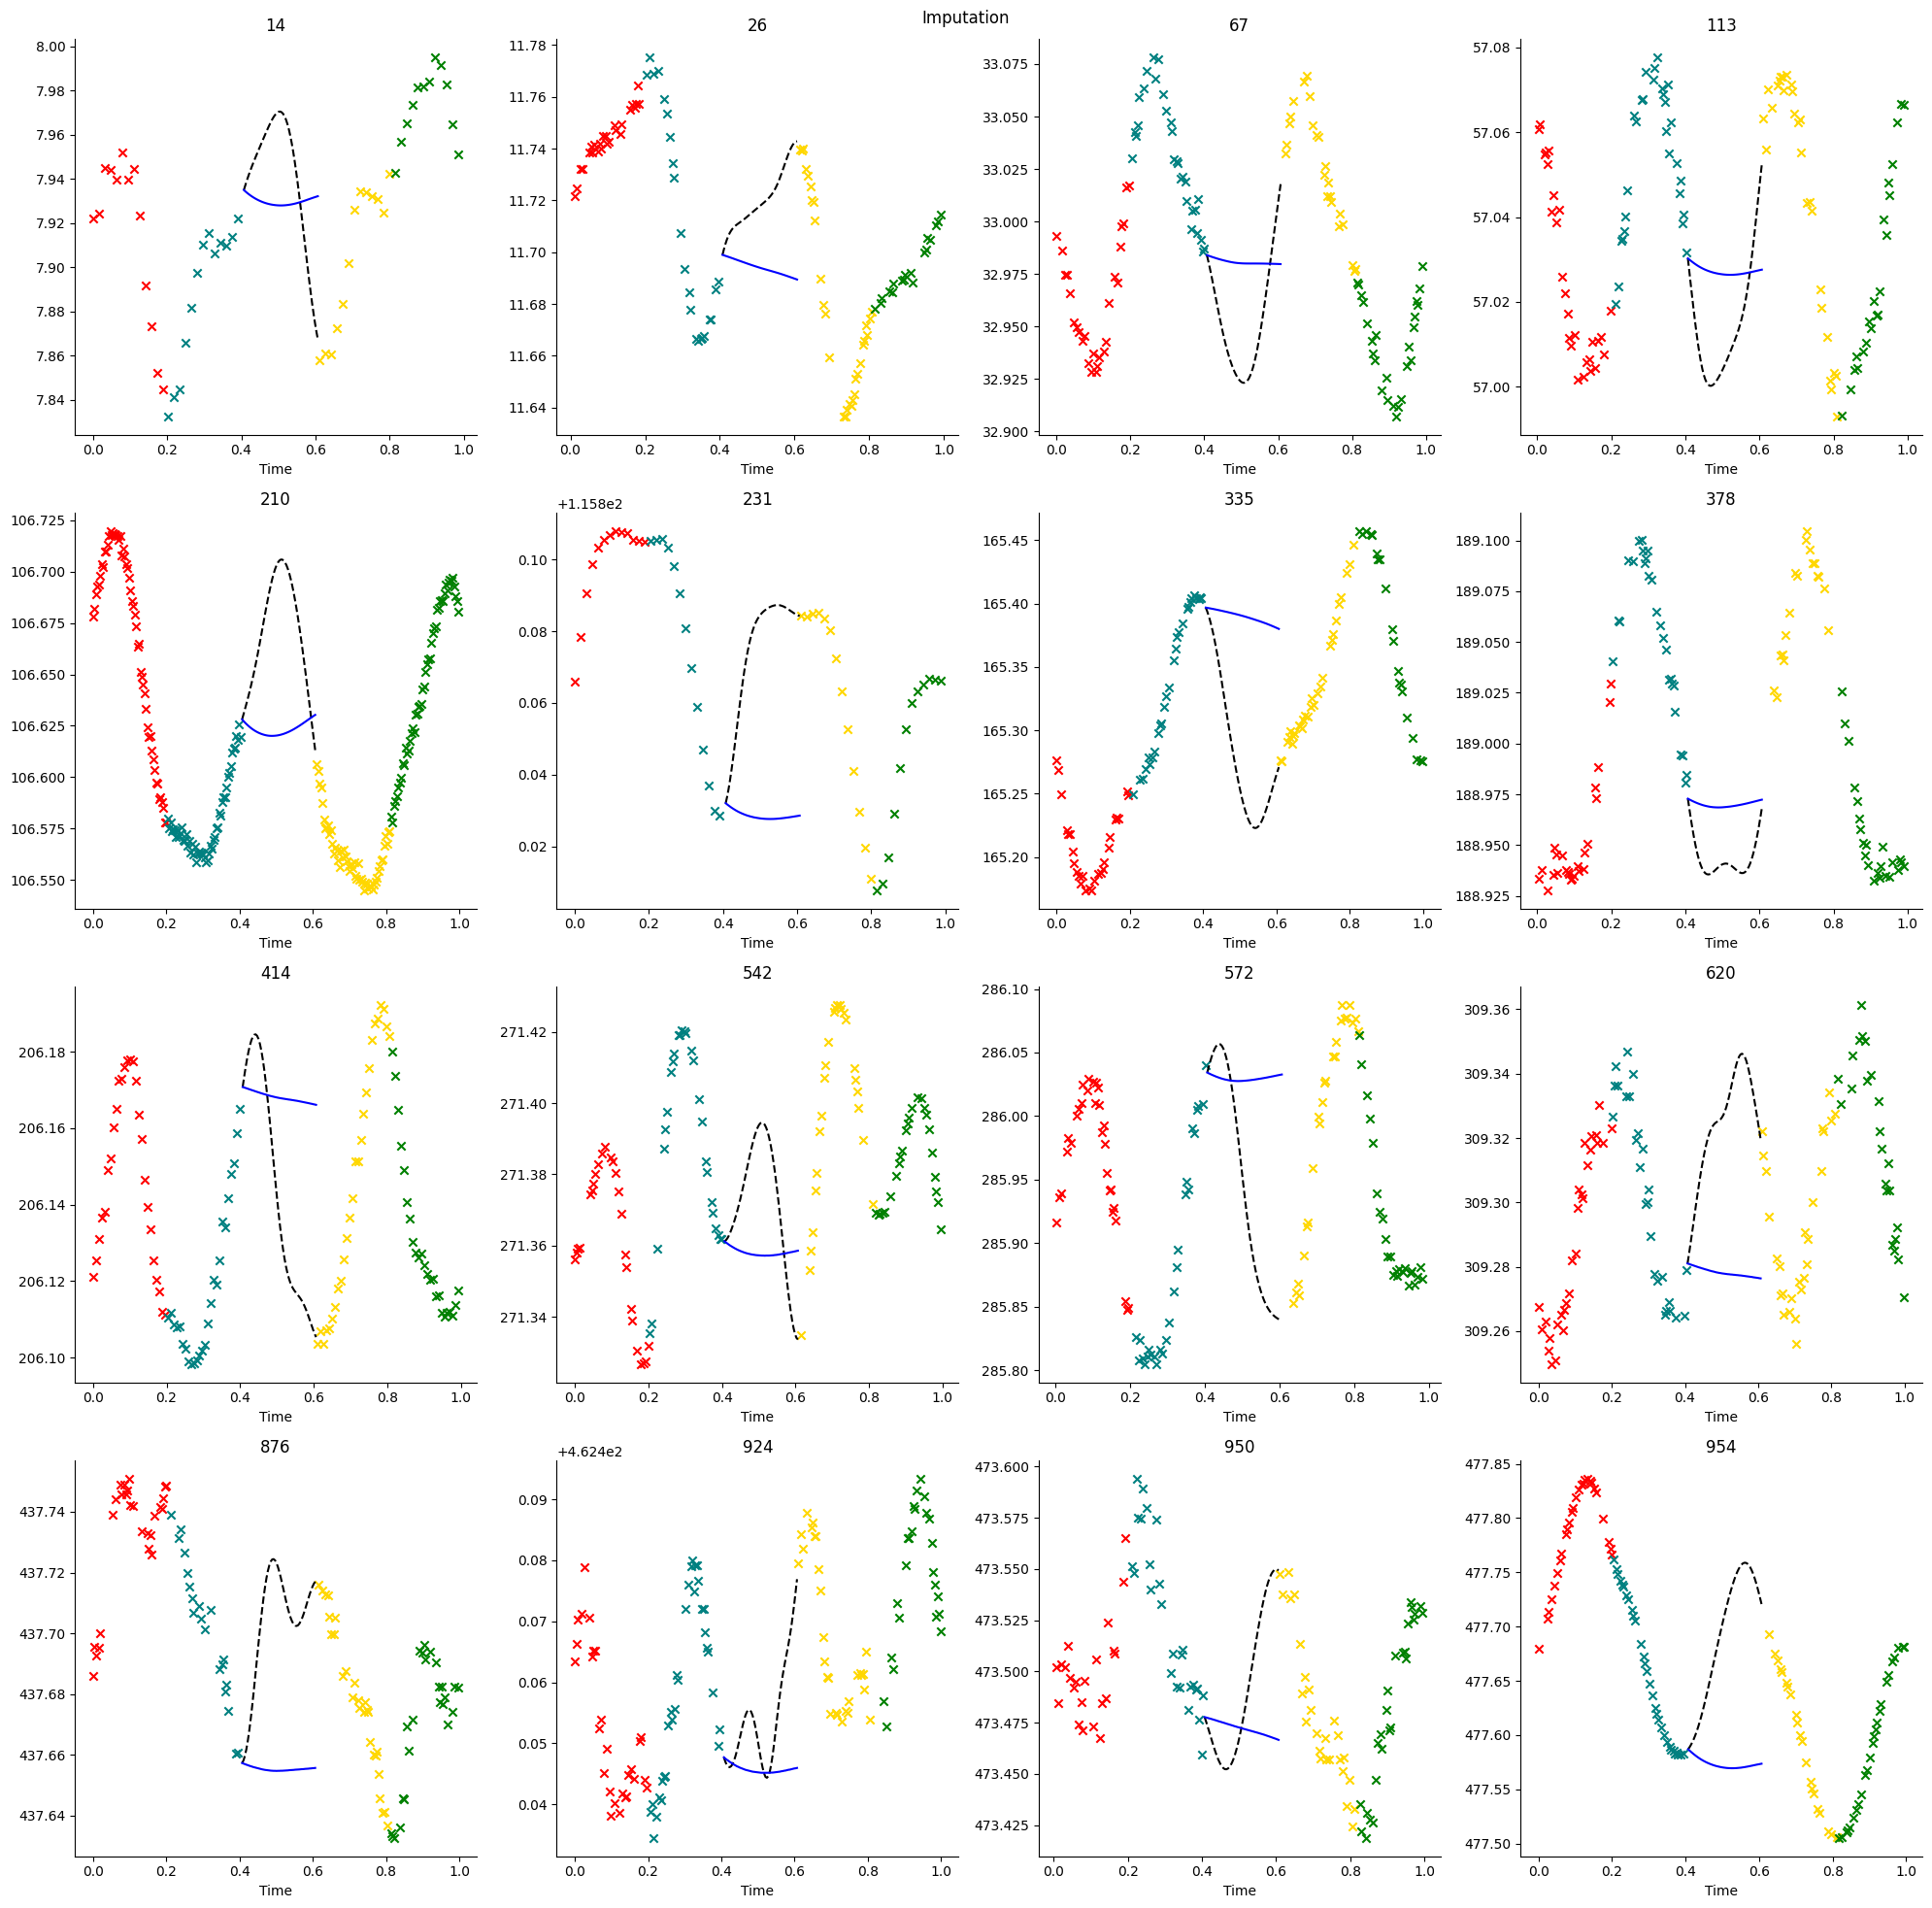

In [5]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for ax, sample_id in zip(axs.flatten(), sample_ids):
    plot_sample(predictions, sample_id, ax)
fig.suptitle("Imputation")
plt.tight_layout()
plt.show()

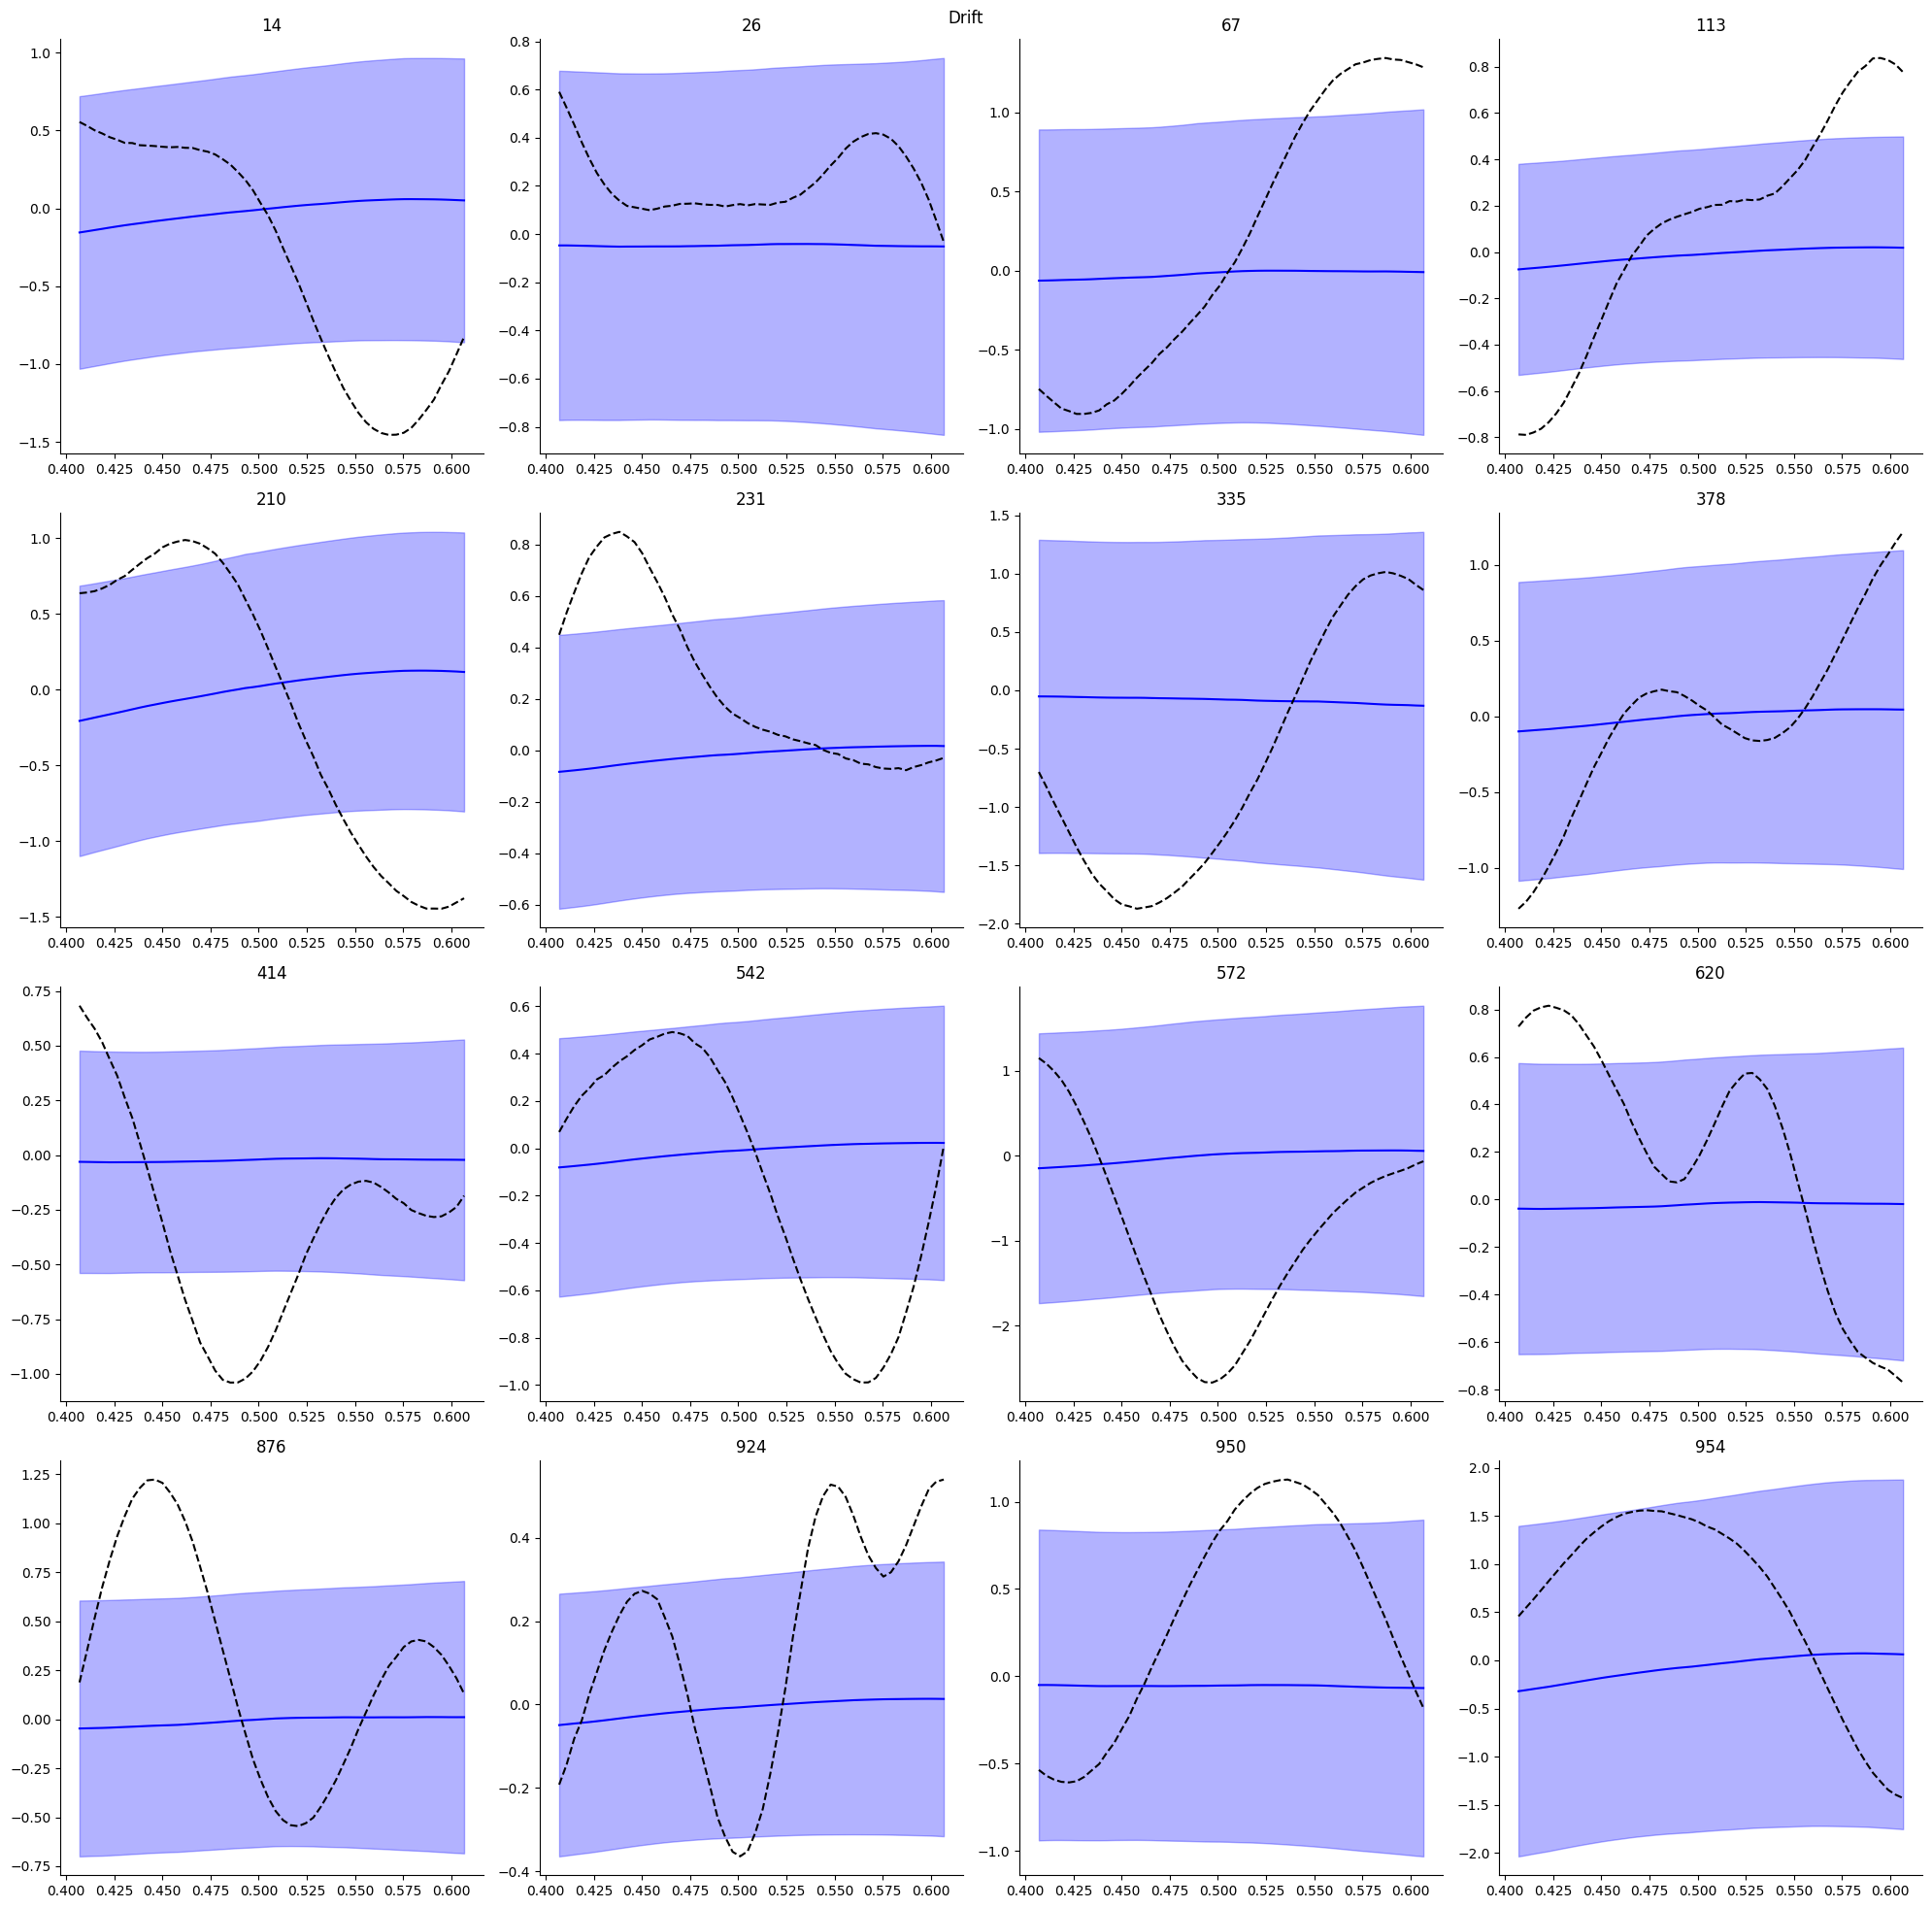

In [6]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
for ax, sample_id in zip(axs.flatten(), sample_ids):
    plot_drift_sample(predictions, sample_id, ax)

fig.suptitle("Drift")
fig.tight_layout()
plt.show()

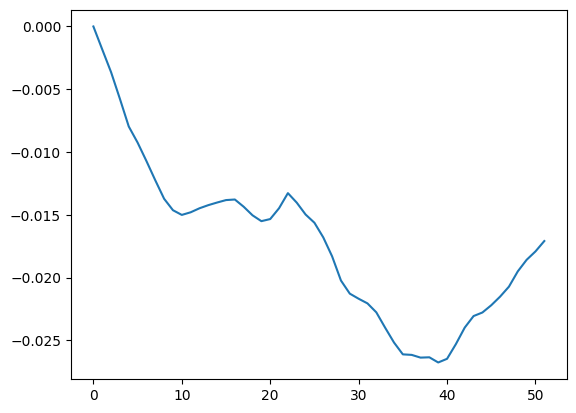

In [7]:
# check if all drift predictions are close
drift = predictions["drift"]["learnt"]
drift = drift - drift[:,0,:].unsqueeze(1)

plt.plot(drift[0]-drift[1])